In [1]:
# Others
# ==============================================================================
import mlflow
import os
import boto3
from io import StringIO
import datetime
from datetime import date
import itertools
from IPython.display import display

# Graphs
# ==============================================================================
import seaborn as sns
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Modeling and Forecasting
# ==============================================================================
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import statsmodels.tsa.arima as ARIMA
import statsmodels.tsa.statespace.sarimax as SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse,rmse
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from statsmodels.tsa.stattools import kpss



In [2]:
os.environ["AWS_PROFILE"] = ("mlops") # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials
#TRACKING_SERVER_HOST = "ec2-52-17-129-153.eu-west-1.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance
#mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

# ==============================================================================
Functions
# ==============================================================================

In [3]:
# Download Data
def download_s3(bucket, data):
    client = boto3.client('s3')
    bucket_name = bucket
    object_key = data
    csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')

    data = pd.read_csv(StringIO(csv_string))
    return data

# Preprocess data
def preprocess_fuelprice(data):
    data['Diesel'] = data['Diesel'] .astype(float)
    data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m-%d")
    data.sort_values(by='Date', inplace = True) 
    data.drop_duplicates(data, inplace = True)
    data= data.groupby([ pd.Grouper(key='Date', freq = 'W-MON')])['Diesel'].mean()

    return data

# Split in train/test
def split_train_test(data, days_test):
    train = data[:-days_test]
    test = data[-days_test:]

    return train,test

# ==============================================================================
Workflow
# ==============================================================================

In [4]:
data = download_s3('gas-prices-project','data.csv')
data = preprocess_fuelprice(data)
train,test = split_train_test(data, 4)
display(train,test)

Date
2018-01-01    1.181000
2018-01-08    1.184571
2018-01-15    1.192857
2018-01-22    1.196143
2018-01-29    1.194857
                ...   
2023-01-23    1.737857
2023-01-30    1.746286
2023-02-06    1.744857
2023-02-13    1.744143
2023-02-20    1.743286
Freq: W-MON, Name: Diesel, Length: 269, dtype: float64

Date
2023-02-27    1.727571
2023-03-06    1.695286
2023-03-13    1.670857
2023-03-20    1.644250
Freq: W-MON, Name: Diesel, dtype: float64

# ==============================================================================
Analyzing 
# ==============================================================================

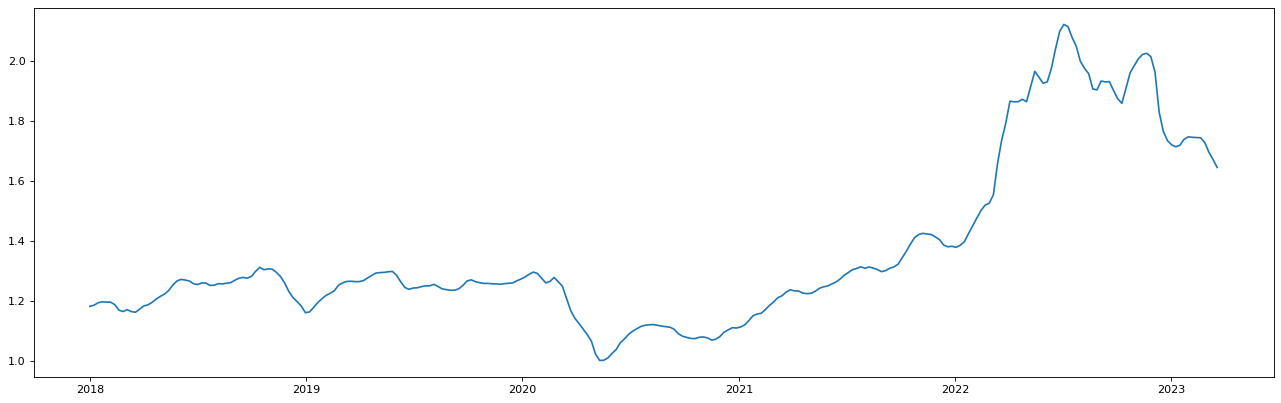

In [81]:
# Data graph (It looks non stationary)
figure(figsize=(20, 6), dpi=80)
plt.plot(data)

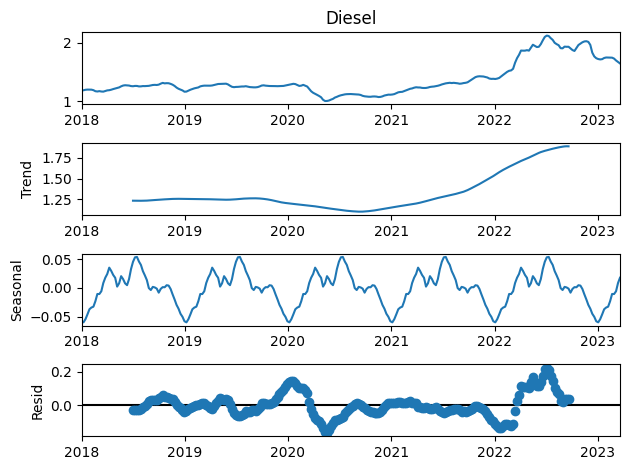

In [79]:
#  Decomposition (It's non stationary. We need to remove trend and seasonality, and make the data stationary, to train the arima model)
decomp = sm.tsa.seasonal_decompose(data, model = "additive", period = 52)
fig = decomp.plot()
plt.show()

In [82]:
# ADF Test
def adf_test (data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, it's stationary")
    else:
        print("weak evidence against null hypothesis, it indicates data is non-stationary")

adf_test(data)


ADF Statistic: -1.241089
p-value: 0.655675
weak evidence against null hypothesis, it indicates data is non-stationary


In [84]:
# Differencing Technique (by 1 week)
data_Diesel_FirstDiff=data-data.shift(1)
data_Diesel_FirstDiff = data_Diesel_FirstDiff.dropna()
data_Diesel_FirstDiff.head()

Date
2018-01-08    0.003571
2018-01-15    0.008286
2018-01-22    0.003286
2018-01-29   -0.001286
2018-02-05    0.000143
Freq: W-MON, Name: Diesel, dtype: float64

In [85]:
# ADF Test (After one differencing,, it's stationary) I (arima) = 1
adf_test(data_Diesel_FirstDiff)

ADF Statistic: -5.330593
p-value: 0.000005
strong evidence against the null hypothesis, it's stationary


c:\Users\saram\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


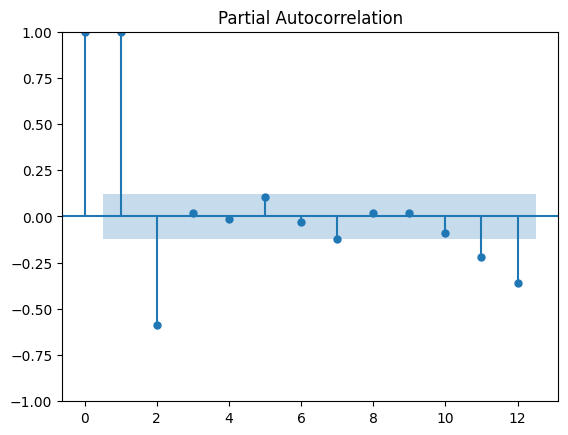

In [88]:
# Check p (2)
plot_pacf(train, lags =12)
plt.show()

In [83]:
# Check D (It's stationary, so we do not need any additional transformation to make it stationary D= 0)
seasonal_dec = decomp.seasonal
adf_test(seasonal_dec)

ADF Statistic: -6.297830
p-value: 0.000000
strong evidence against the null hypothesis, it's stationary


c:\Users\saram\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


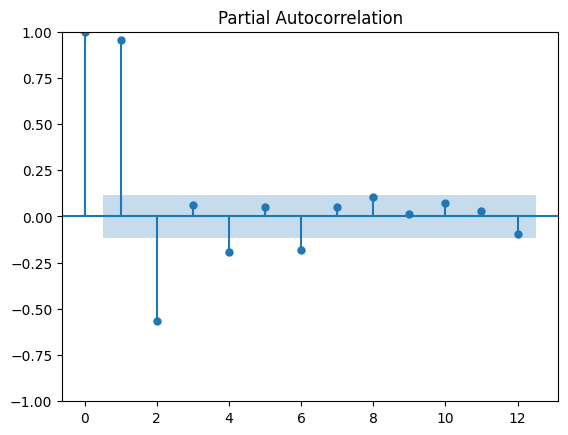

In [85]:
# P = 6
plot_pacf(seasonal_dec, lags =12)
plt.show()

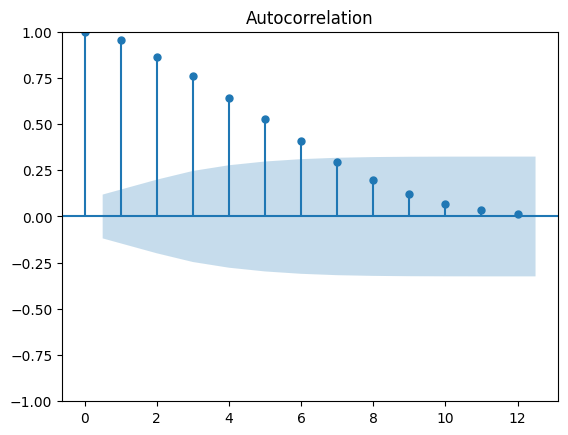

In [86]:
# Q = 6
plot_acf(seasonal_dec, lags =12)
plt.show()

# ==============================================================================
Modeling 
# ==============================================================================

In [128]:
# Run auto-arima to obtain recommnended orders
model_autoarima = auto_arima(train, m=12,enforce_invertibility=False)
model_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  269
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 760.097
Date:                Sun, 19 Mar 2023   AIC                          -1512.194
Time:                        23:41:34   BIC                          -1497.830
Sample:                    01-01-2018   HQIC                         -1506.425
                         - 02-20-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1634      0.097      1.688      0.091      -0.026       0.353
ar.L2          0.2817      0.091      3.104      0.002       0.104       0.460
ma.L1          0.7282      0.079      9.202      0.000       0.573       0.883
sigma2         0.0002   7.62e-06     26.335      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1609.63
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):              12.20   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

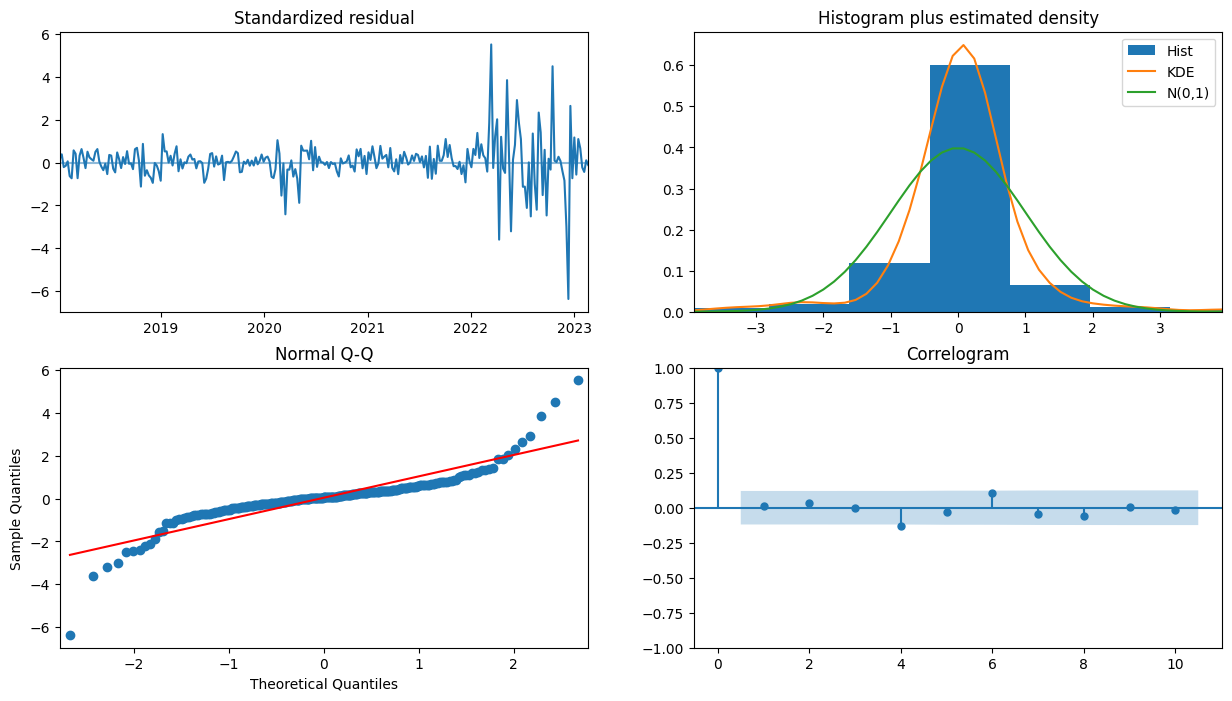

In [54]:
model_autoarima.plot_diagnostics(figsize=(15,8))
plt.show()

In [92]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
model = SARIMAX.SARIMAX(train,order=(2,1,1),seasonal_order=(6,0,6,12),enforce_invertibility=False)
results = model.fit()
predictions = results.predict(start=start, end=end, dynamic=False).rename('Predicted')

c:\Users\saram\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Text(0.5, 0, ''), Text(0, 0.5, 'Price')]

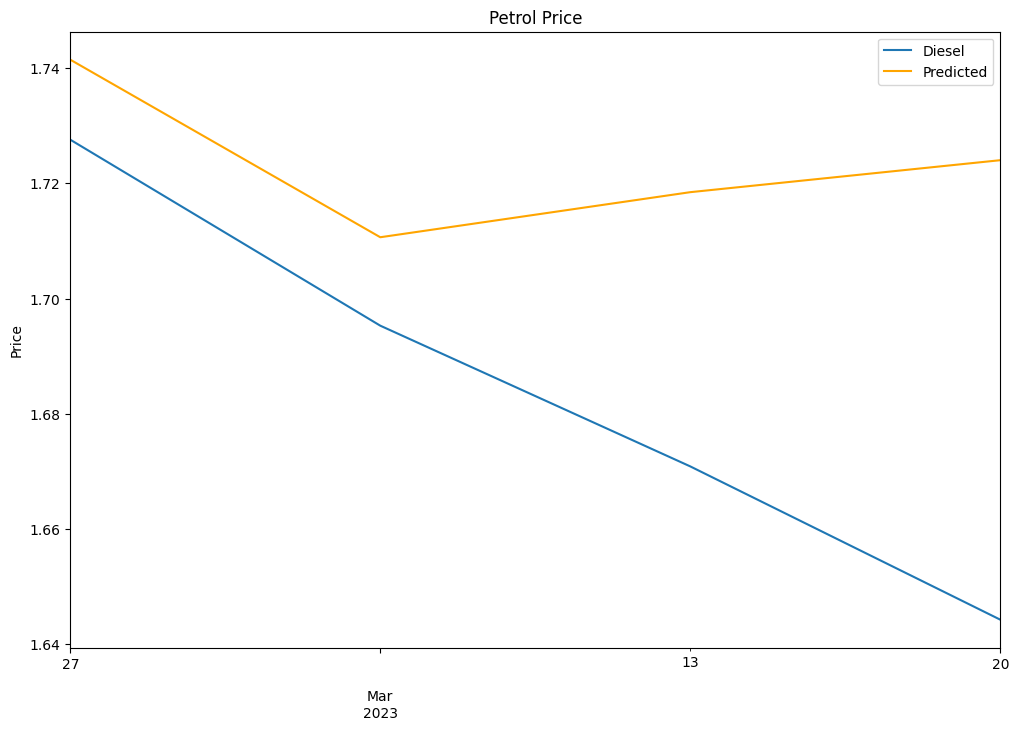

In [93]:
# Plot predictions against known values
title='Petrol Price'
ylabel='Price'
xlabel=''

ax = test.plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

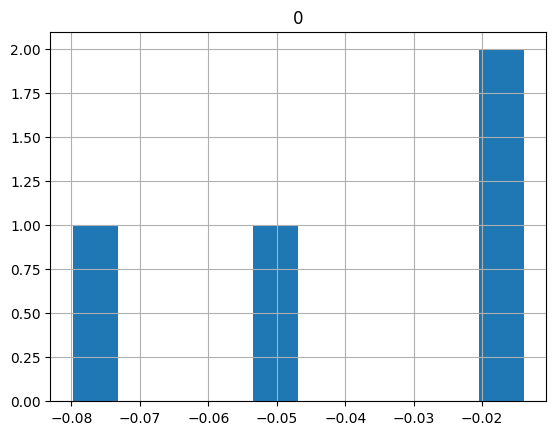

In [94]:
# calculate residuals
residuals = test-predictions 
residuals = pd.DataFrame(residuals)
residuals.hist()


In [95]:
# Retrain the model on the full data, and forecast the future
model = SARIMAX.SARIMAX(data,order=(2,1,1),seasonal_order=(6,0,6,12),enforce_invertibility=False)
results = model.fit()
fcast = results.predict(len(data),len(data)+14).rename('Forecast')

[Text(0.5, 0, ''), Text(0, 0.5, 'Price')]

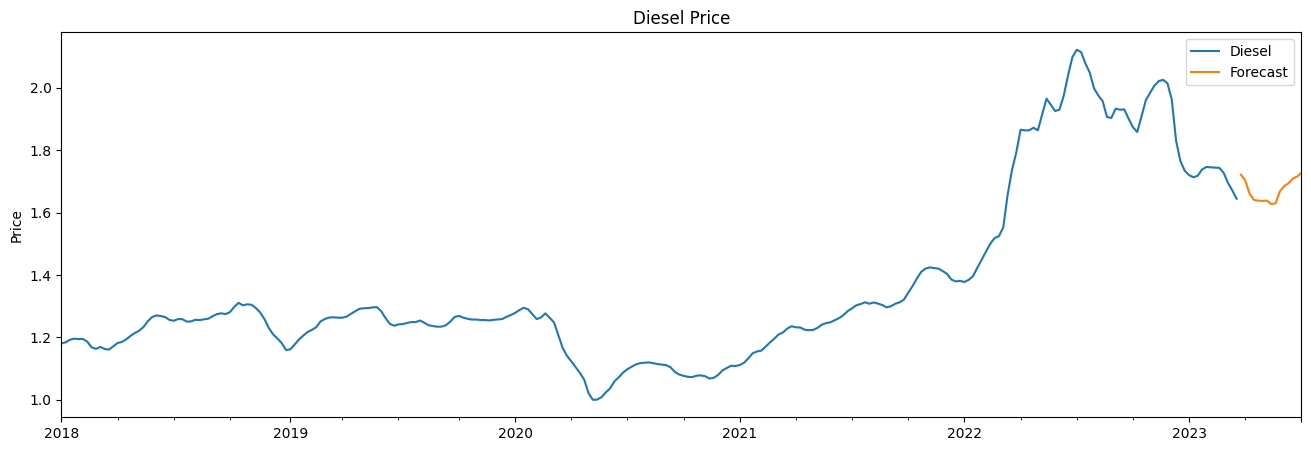

In [96]:
# Plot the forecast alongside historical values
title='Diesel Price'
ylabel='Price'
xlabel=''

ax = data.plot(legend=True,figsize=(16,5),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [41]:
mse(test, predictions)

NameError: name 'predictions' is not defined

In [95]:
rmse(test, predictions)

0.020005861293089174

# ==============================================================================
MLFlow
# ==============================================================================

In [129]:
# Basic MLFlow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("SARIMAX")

with mlflow.start_run(run_name='arima_param'):

    q = 1
    d = 1
    p = 1

    mlflow.set_tag("developer", "sara")
    mlflow.set_tag("model", "SARIMAX")
    mlflow.log_param("q", q)
    mlflow.log_param("d", q)
    mlflow.log_param("p", q)

    model_sarimax = SARIMAX.SARIMAX(train,order=(p,d,q),enforce_invertibility=False)
    results = model_sarimax.fit()

    start=len(train)
    end=len(train)+len(test)-1

    predictions = results.predict(start=start, end=end, dynamic=False)
    rmse_ = rmse(test, predictions)
    mlflow.log_metric("rmse", rmse_)    

In [ ]:
# Complex MLFlow
# Paramters
p = range(0,3)
d = range(0,2)
q = range(0,3)

P = range(0,3)
D = range(0,2)
Q = range(0,3)

parameters = itertools.product(p, d, q, P, D, Q)
parameters_list = list(parameters)
len(parameters_list)

# Model loop
for param in parameters_list:
     with mlflow.start_run(run_name='SARIMAX_param'):

          # Log 
          mlflow.set_tag("model", "SARIMAX")
          mlflow.log_param('order-p', param[0])
          mlflow.log_param('order-d', param[1])
          mlflow.log_param('order-q', param[2])
          mlflow.log_param('order-P', param[3])
          mlflow.log_param('order-D', param[4])
          mlflow.log_param('order-Q', param[5])     
          
          # SARIMAX
          try:
               model_sarimax = SARIMAX.SARIMAX(train, order=(param[0], param[1],param[2]), seasonal_order=(param[3], param[4], param[5], 52))

          except ValueError:
               print('bad parameter combination:', param)    
                          
               continue
          results = model_sarimax.fit()
          start=len(train)
          end=len(train)+len(test)-1
          predictions = results.predict(start=start, end=end, dynamic=False)

          # rmse metric
          rmse_ = rmse(test, predictions)          
          mlflow.log_metric("rmse", rmse_)  

          # model
          mlflow.statsmodels.log_model(results, artifact_path = "models")


In [8]:
logged_model = './mlruns/1/c44a2e55c3bb47688de381cdd2006328/artifacts/models'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model


mlflow.pyfunc.loaded_model:
  artifact_path: models
  flavor: mlflow.statsmodels
  run_id: c44a2e55c3bb47688de381cdd2006328

In [9]:
model = mlflow.statsmodels.load_model(logged_model)
model

In [13]:
start=len(train)
end=len(train)+len(test)-1
model.predict(start=start, end=end)

2023-02-27    1.524714
2023-03-06    1.552857
2023-03-13    1.656714
2023-03-20    1.735143
Freq: W-MON, Name: predicted_mean, dtype: float64

In [14]:
from mlflow.tracking import MlflowClient

mlflow_tracking_uri = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri = mlflow_tracking_uri)

In [104]:
from mlflow.entities import ViewType
runs = client.search_runs(
   experiment_ids= '1',
   filter_string="metrics.rmse < 0.2",
   run_view_type= ViewType.ACTIVE_ONLY,
   max_results= 1,
   order_by=["metrics.rmse ASC"]
)

runs


[<Run: data=<RunData: metrics={'rmse': 0.06403806249138914}, params={'order-D': '0',
  'order-P': '1',
  'order-Q': '1',
  'order-d': '0',
  'order-p': '1',
  'order-q': '1'}, tags={'mlflow.log-model.history': '[{"run_id": "afa8b356709c4fd99f97b38da7b4b181", '
                              '"artifact_path": "models", "utc_time_created": '
                              '"2023-03-21 12:04:22.521633", "flavors": '
                              '{"python_function": {"loader_module": '
                              '"mlflow.statsmodels", "python_version": "3.9.4", '
                              '"data": "model.statsmodels", "env": {"conda": '
                              '"conda.yaml", "virtualenv": "python_env.yaml"}}, '
                              '"statsmodels": {"statsmodels_version": "0.13.5", '
                              '"data": "model.statsmodels", "code": null}}, '
                              '"model_uuid": '
                              '"cedd7c2efb0347c09fc226d16b91c8db

In [30]:
for run in runs:
    print(f"run id: {run.info.run_id }, rmse: {run.data.metrics['rmse']:.4f}") 

run id: c44a2e55c3bb47688de381cdd2006328, rmse: 0.1322
run id: 4461596316c04ccf9a342ba482709db0, rmse: 0.1507
run id: 6c5f729aada04187b3fb6222853ee00b, rmse: 0.1515
run id: 993e1ba3faf64baa9721e95428ba1d03, rmse: 0.1744


In [31]:
# Register a new version of the model
mlflow.set_tracking_uri(mlflow_tracking_uri)
run_id = "6c5f729aada04187b3fb6222853ee00b"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri= model_uri, name = "fuel-price-predict")

Registered model 'fuel-price-predict' already exists. Creating a new version of this model...
2023/03/20 23:49:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: fuel-price-predict, version 3
Created version '3' of model 'fuel-price-predict'.


<ModelVersion: creation_timestamp=1679352583453, current_stage='None', description=None, last_updated_timestamp=1679352583453, name='fuel-price-predict', run_id='6c5f729aada04187b3fb6222853ee00b', run_link=None, source='./mlruns/1/6c5f729aada04187b3fb6222853ee00b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [36]:
# Transition a model
model_name = "fuel-price-predict"
latest_versions = client.get_latest_versions(name= model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Production
version: 2, stage: Staging
version: 3, stage: None


In [37]:
model_version = 3
new_stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1679352583453, current_stage='Staging', description=None, last_updated_timestamp=1679353150708, name='fuel-price-predict', run_id='6c5f729aada04187b3fb6222853ee00b', run_link=None, source='./mlruns/1/6c5f729aada04187b3fb6222853ee00b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [38]:
from datetime import datetime

date = datetime.today().date()
client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

<ModelVersion: creation_timestamp=1679352583453, current_stage='Staging', description='The model version 3 was transitioned to Staging on 2023-03-21', last_updated_timestamp=1679353206976, name='fuel-price-predict', run_id='6c5f729aada04187b3fb6222853ee00b', run_link=None, source='./mlruns/1/6c5f729aada04187b3fb6222853ee00b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>